In [4]:
#Importer les libraries pour dataframe et visualisation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Importer les libraraies pour le clustering*

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import DBSCAN
import pickle
import warnings
warnings.filterwarnings("ignore")

In [5]:
# IMPORTATION DES DONNEES POUR LE PROJET



df = pd.read_excel('/Users/apple/Desktop/MODULE MACHINE LEARNING/Online Retail.xlsx')


In [6]:
# afficher le dataframe

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
# les informations du dataframe

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
# description du dataframe

df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
# calculer les valeurs manquantes en %

df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [10]:
# retirer les valeurs manquantes

df = df.dropna()
df.shape

(406829, 8)

In [11]:
# Changer le type de données de l'identifiant du client selon la description des données métier

df['CustomerID'] = df['CustomerID'].astype(str)

# PREPARATION DES DONNEES
## Nous allons analyser les clients en fonction des 3 facteurs suivants :
R (Récence) : Nombre de jours depuis le dernier achat
F (Fréquence) : Nombre de transactions
M (Monétaire) : Montant total des transactions (revenus générés).

In [15]:
# calcul de l'attribut Monetaire


df['Amount'] = df['Quantity']*df['UnitPrice']
rfm_m = df.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [16]:
#  calcul de l'attribut Frequence


rfm_f = df.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [17]:
#  Calcul de l'attribut recence

# convertir la colonne de date en un format de date et d'heure 

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')

# calculer la date la plus recente de la base
latest_date = df['InvoiceDate'].max()

# calculer la difference entre la date la plus recente et la date de la derniere transaction
df['Diff'] = (latest_date - df['InvoiceDate']).dt.days

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373


In [18]:
# Calculer la date de la dernière transaction pour obtenir la récence des clients

rfm_r = df.groupby('CustomerID')['Diff'].min()
rfm_r = rfm_r .reset_index()
rfm_r .head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [19]:
#Fusionner les dataframes pour obtenir le dataframe final RFM

#Fusionner les deux dataframes.

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [20]:
rfm= pd.merge(rfm, rfm_r, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

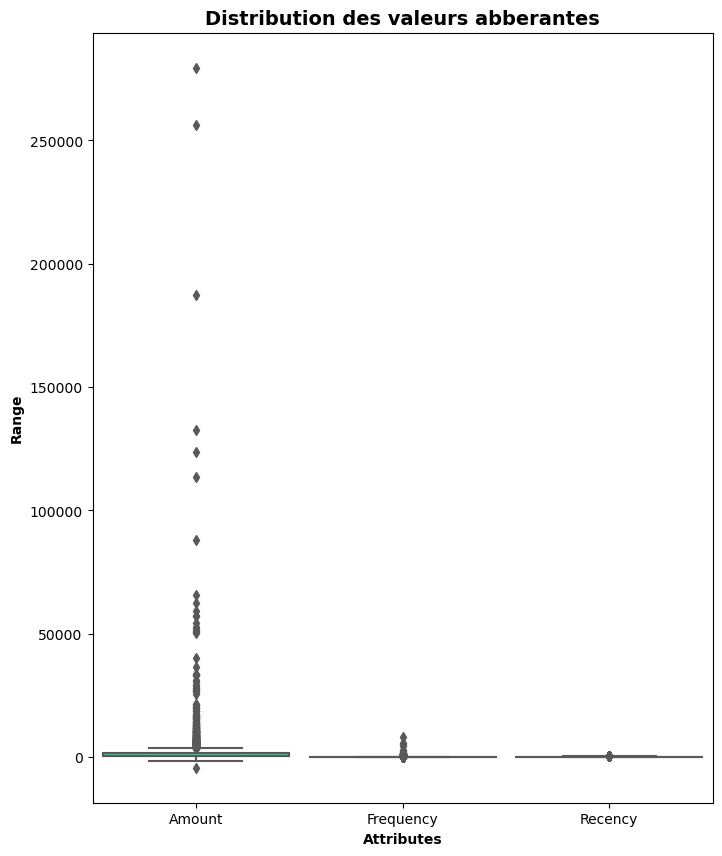

In [21]:
# Analyse des valeurs aberrantes de la fréquence des montants et de la récence (box plot)

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [8,10]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.9)
plt.title("Distribution des valeurs abberantes", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')


In [22]:
# Retirer les valeurs aberrantes de Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

In [23]:
# Retirer les valeurs aberrantes de Recence
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]


In [24]:
# Retirer les valeurs aberrantes de Frenquence
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

# Mise à l'échelle des attributs par la standardisation (standar scaler) 

In [25]:
# Mise à l'échelle des attributs

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]
scaler = StandardScaler()
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape


(4293, 3)

In [26]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


# CONSTRUCTION DU MODELE

## K-MEANS



In [27]:
# Definir le nombre des clusters

n_clusters = 3

# Modele KMeans 

kmeans = KMeans(n_clusters, random_state=0) 
kmeans.fit(rfm_df_scaled)

KMeans(n_clusters=3, random_state=0)

In [28]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0], dtype=int32)

## Trouver le nombre optimal des clusters


In [29]:
#Elbow-curve

l = []

for num_clusters in range(1,11):
    kmeans = KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    l.append(kmeans.inertia_)

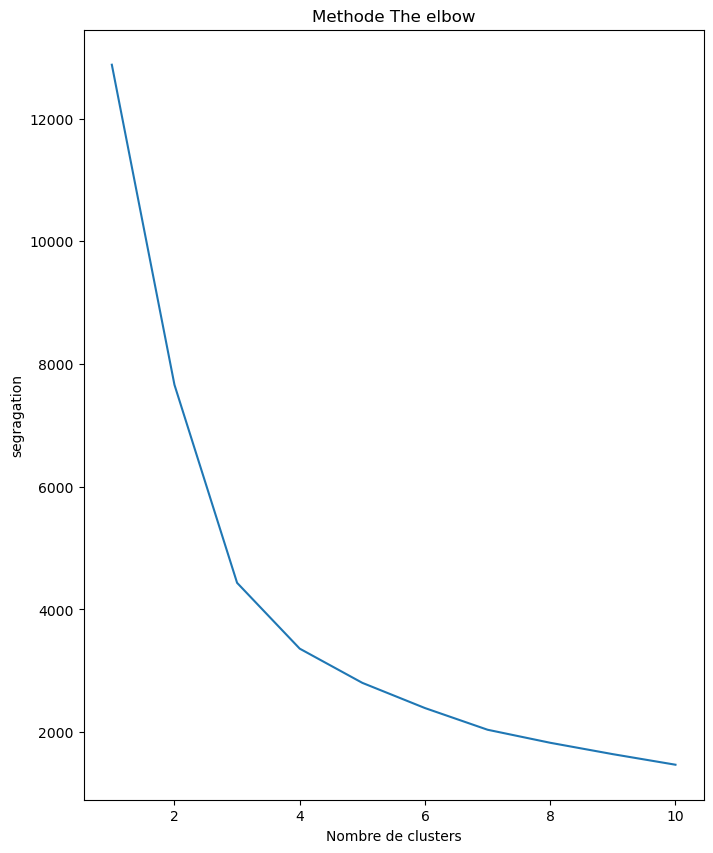

In [30]:
plt.plot(range(1,11), l)
plt.title('Methode The elbow')
plt.xlabel('Nombre de clusters')
plt.ylabel('segragation')
plt.show()

## Analyse Silhouette

In [31]:

for num_clusters in range(2,10):
    
    #  kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("Pour n_clusters={0}, la silhouette score est {1}".format(num_clusters, silhouette_avg))
    

Pour n_clusters=2, la silhouette score est 0.5411246404292333
Pour n_clusters=3, la silhouette score est 0.5084896296141937
Pour n_clusters=4, la silhouette score est 0.48148099614734263
Pour n_clusters=5, la silhouette score est 0.46627005641897035
Pour n_clusters=6, la silhouette score est 0.4175495621530355
Pour n_clusters=7, la silhouette score est 0.4156699275127462
Pour n_clusters=8, la silhouette score est 0.40218520093564997
Pour n_clusters=9, la silhouette score est 0.4143110199976141


In [32]:
# Le model final avec k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [33]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0], dtype=int32)

In [34]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

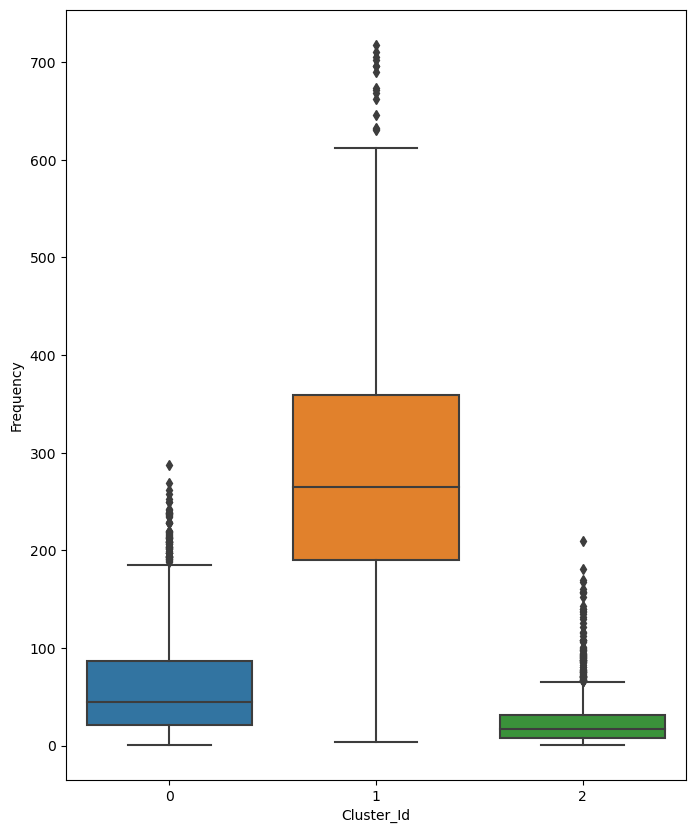

In [35]:
# Boite a moustache pour visualiser les clusters vs la frequence

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Recency'>

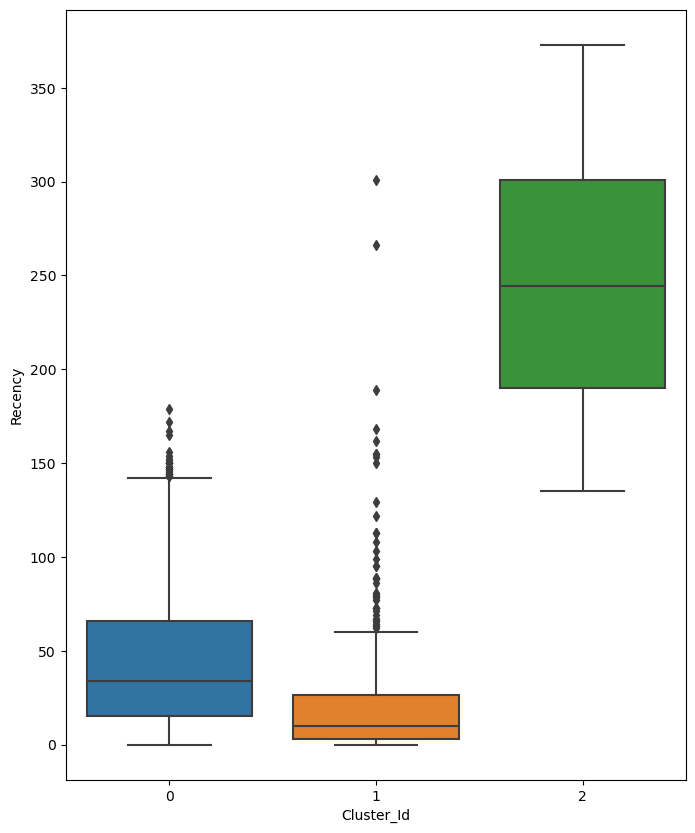

In [36]:
# Boite a moustache pour visualiser les clusters vs la recence

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Amount'>

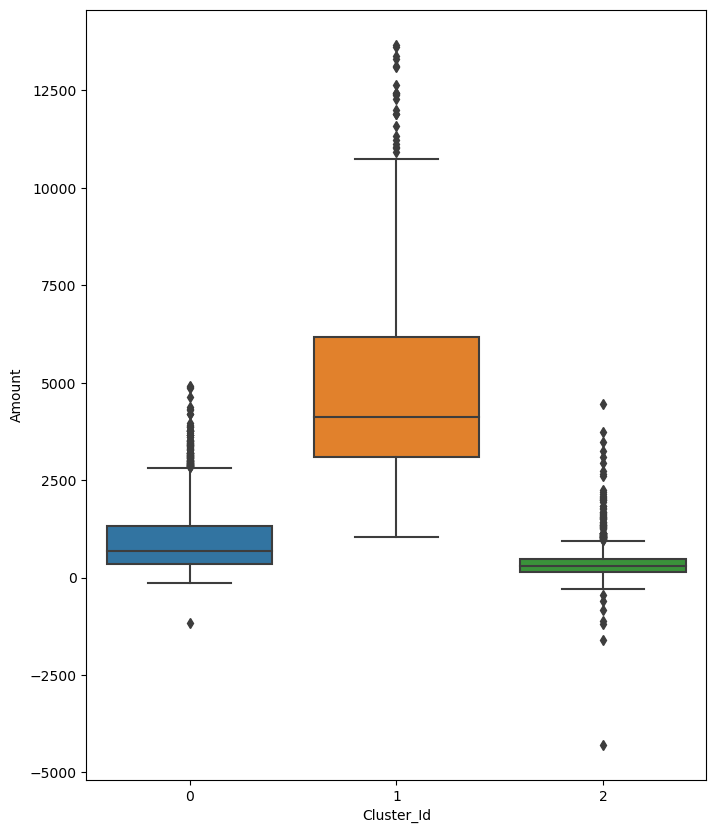

In [37]:
# Boite a moustache pour visualiser les clusters vs monetaire

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

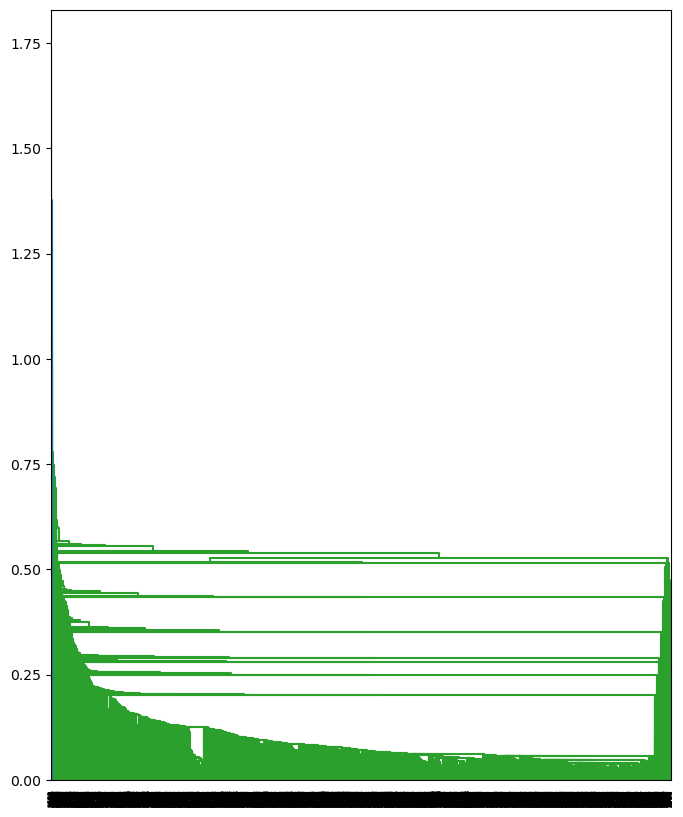

In [38]:
#Hierarchical Clustering

# Liaison simple: 


mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

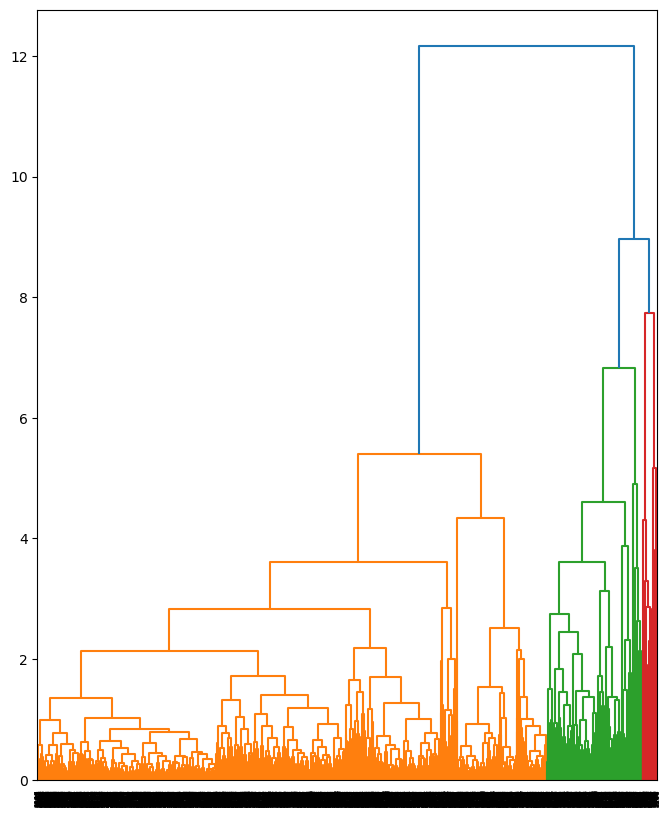

In [43]:
 #Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

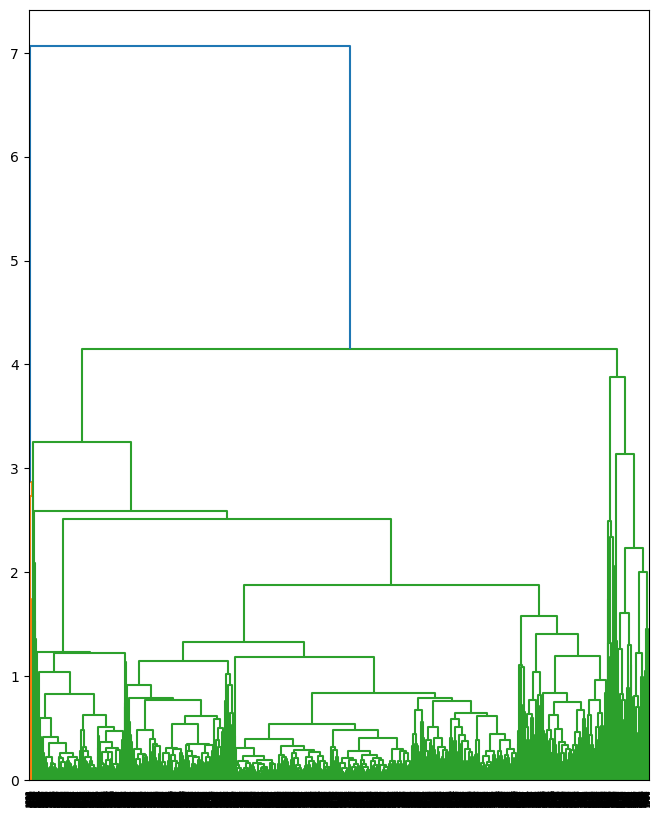

In [44]:
# Average linkage

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

*La méthode de liaison de Ward, utilisée dans la classification hiérarchique, se distingue par sa robustesse aux valeurs aberrantes. Elle vise à minimiser la variance à l'intérieur des clusters, rendant ainsi le regroupement moins sensible aux points de données atypiques. En favorisant la formation de clusters avec une faible variance  interne, la méthode de Ward cherche à créer des groupes homogènes et compacts. Elle est donc un choix approprié lorsque la présence de valeurs aberrantes pourrait avoir un impact négatif sur la qualité des clusters.*

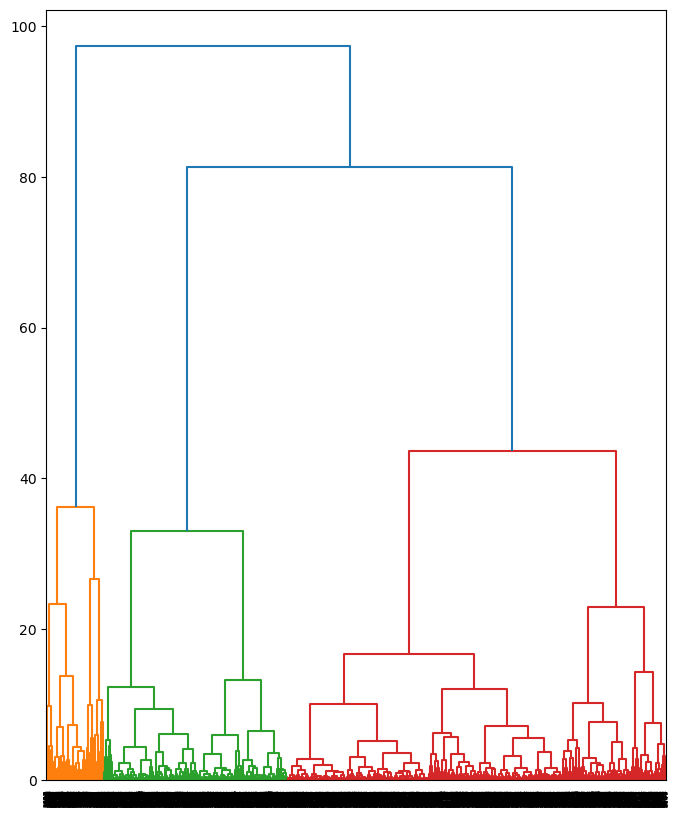

In [45]:
#Ward Linkage

mergings = linkage(rfm_df_scaled, method="ward", metric='euclidean')
dendrogram(mergings)
plt.show()

In [46]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 2, ..., 0, 2, 2])

In [47]:
# Attribuer des titres aux clusters

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,1,1
2,12348.0,1797.24,31,74,0,2
3,12349.0,1757.55,73,18,0,2
4,12350.0,334.40,17,309,2,0


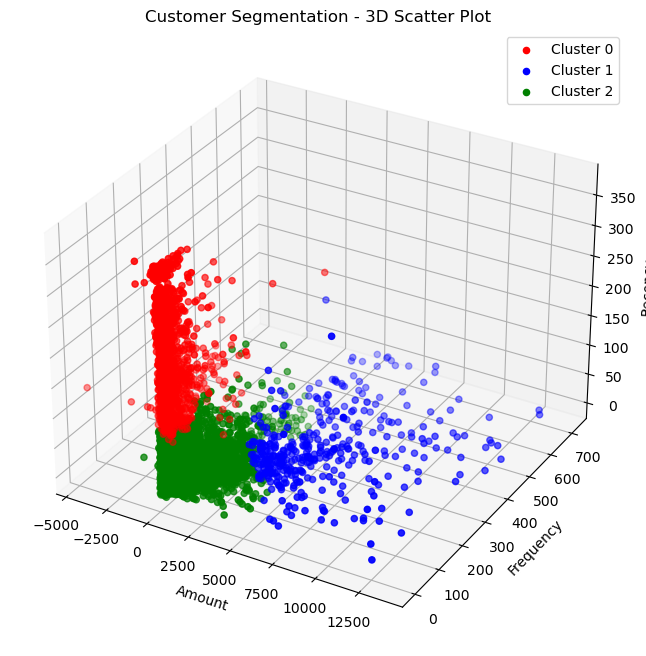

In [48]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract features and cluster IDs
x = rfm['Amount']
y = rfm['Frequency']
z = rfm['Recency']
cluster_ids = rfm['Cluster_Labels']

# Scatter plot for the clusters
ax.scatter(x[cluster_ids == 0], y[cluster_ids == 0], z[cluster_ids == 0], c='red', label='Cluster 0')
ax.scatter(x[cluster_ids == 1], y[cluster_ids == 1], z[cluster_ids == 1], c='blue', label='Cluster 1')
ax.scatter(x[cluster_ids == 2], y[cluster_ids == 2], z[cluster_ids == 2], c='green', label='Cluster 2')

# Set plot labels and title
ax.set_xlabel('Amount')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.set_title('Customer Segmentation - 3D Scatter Plot')

# Show legend and plot
plt.legend()
plt.show()


<Axes: xlabel='Cluster_Labels', ylabel='Amount'>

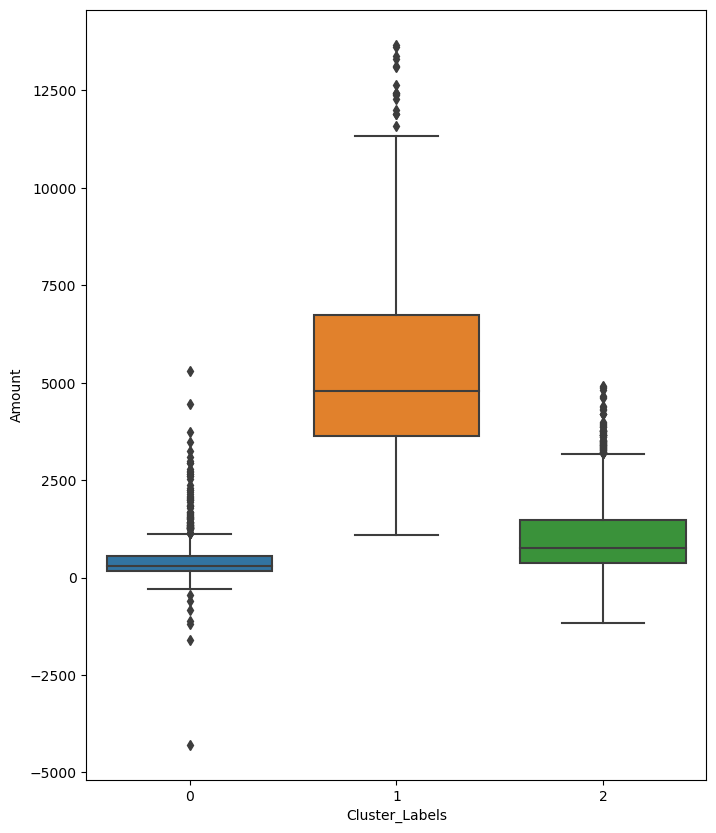

In [49]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Labels', ylabel='Recency'>

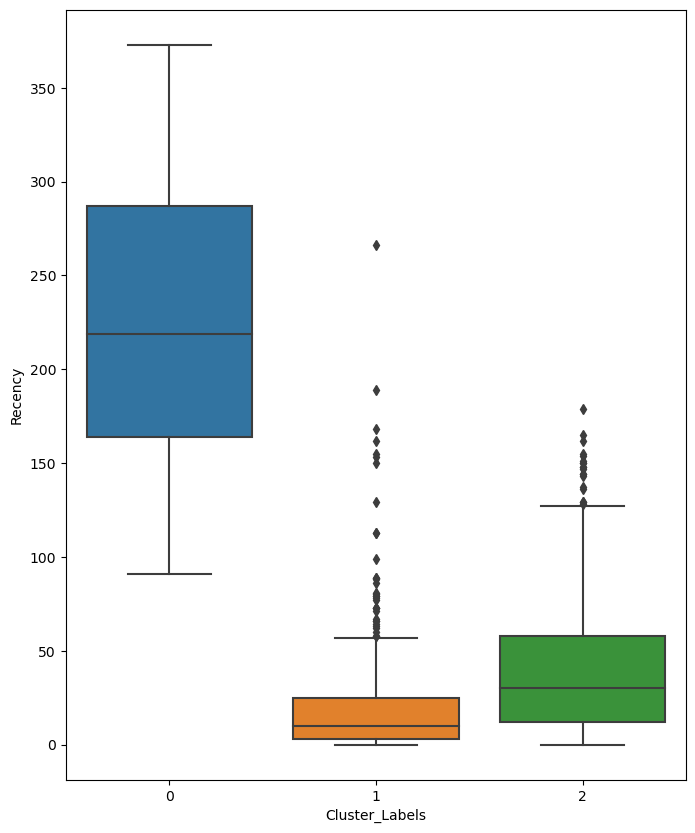

In [50]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

<Axes: xlabel='Cluster_Labels', ylabel='Frequency'>

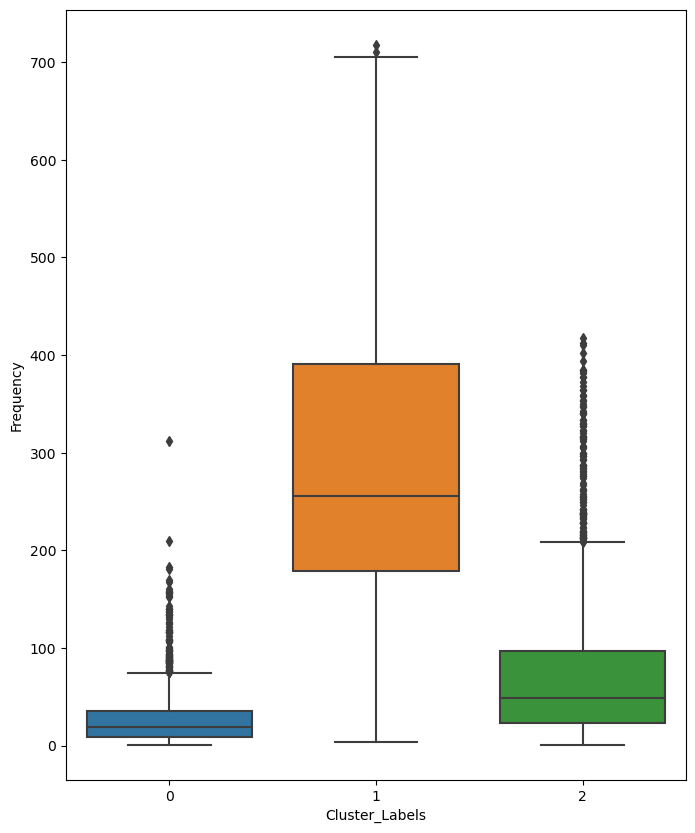

In [51]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

*La méthode de classification hiérarchique a également indiqué un résultat similaire à l'algorithme K-means, suggérant la présence de trois clusters. Cependant, malgré la cohérence dans le nombre de clusters, des valeurs aberrantes restent évidentes dans les données.*

# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [52]:
dbscan = DBSCAN(eps=0.2, min_samples=15, metric='euclidean')
dbscan.fit(rfm_df_scaled)
cluster_db = dbscan.labels_

In [53]:
cluster_db

array([ 0, -1,  0, ...,  0,  0,  0])

In [54]:
# Attribuer les titres aux clusters

rfm['cluster_db'] = cluster_db
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels,cluster_db
0,12346.0,0.00,2,325,2,0,0
1,12347.0,4310.00,182,1,1,1,-1
2,12348.0,1797.24,31,74,0,2,0
3,12349.0,1757.55,73,18,0,2,0
4,12350.0,334.40,17,309,2,0,0


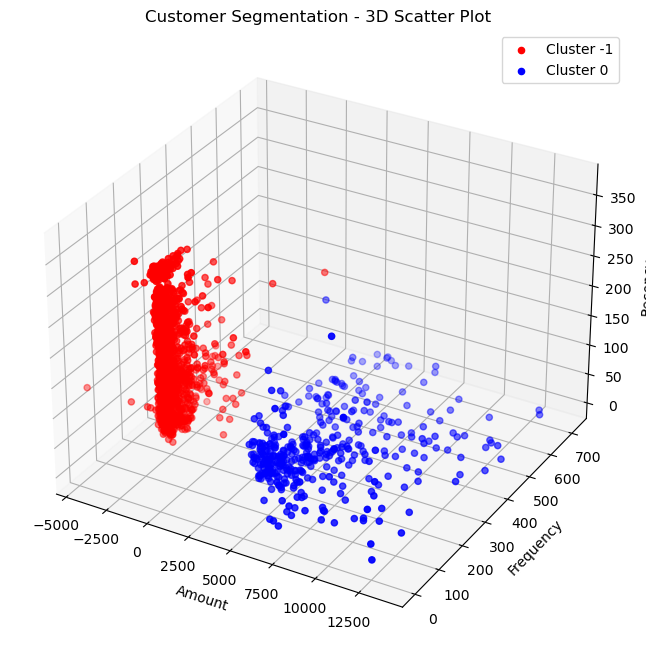

In [55]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract features and cluster IDs
x = rfm['Amount']
y = rfm['Frequency']
z = rfm['Recency']
cluster_ids = rfm['Cluster_Labels']

# Scatter plot for the clusters
ax.scatter(x[cluster_ids == 0], y[cluster_ids == 0], z[cluster_ids == 0], c='red', label='Cluster -1')
ax.scatter(x[cluster_ids == 1], y[cluster_ids == 1], z[cluster_ids == 1], c='blue', label='Cluster 0')

# Set plot labels and title
ax.set_xlabel('Amount')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.set_title('Customer Segmentation - 3D Scatter Plot')

# Show legend and plot
plt.legend()
plt.show()


<Axes: xlabel='cluster_db', ylabel='Amount'>

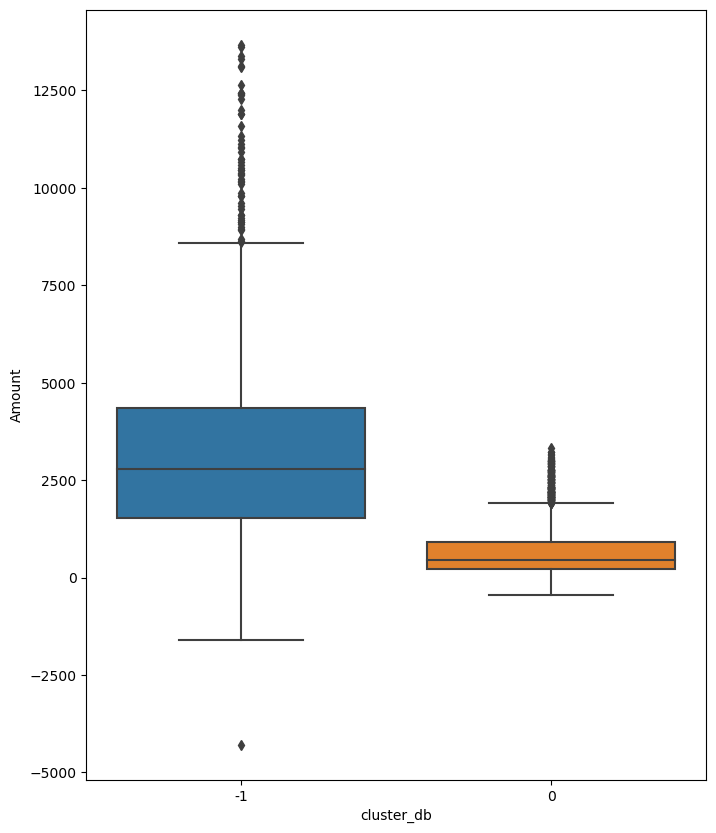

In [56]:
# Plot Cluster Id vs Amount

sns.boxplot(x='cluster_db', y='Amount', data=rfm)

<Axes: xlabel='cluster_db', ylabel='Frequency'>

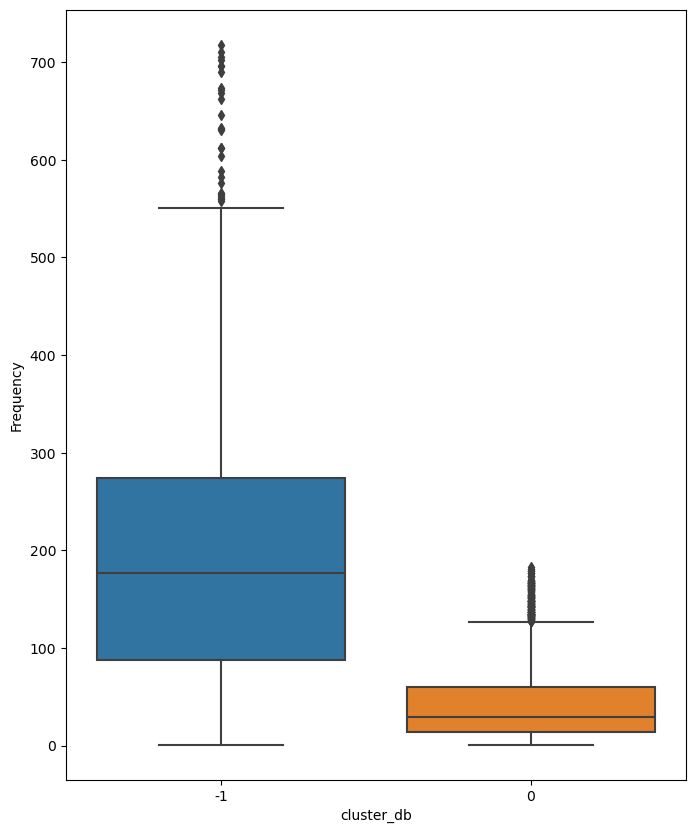

In [57]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='cluster_db', y='Frequency', data=rfm)

<Axes: xlabel='cluster_db', ylabel='Recency'>

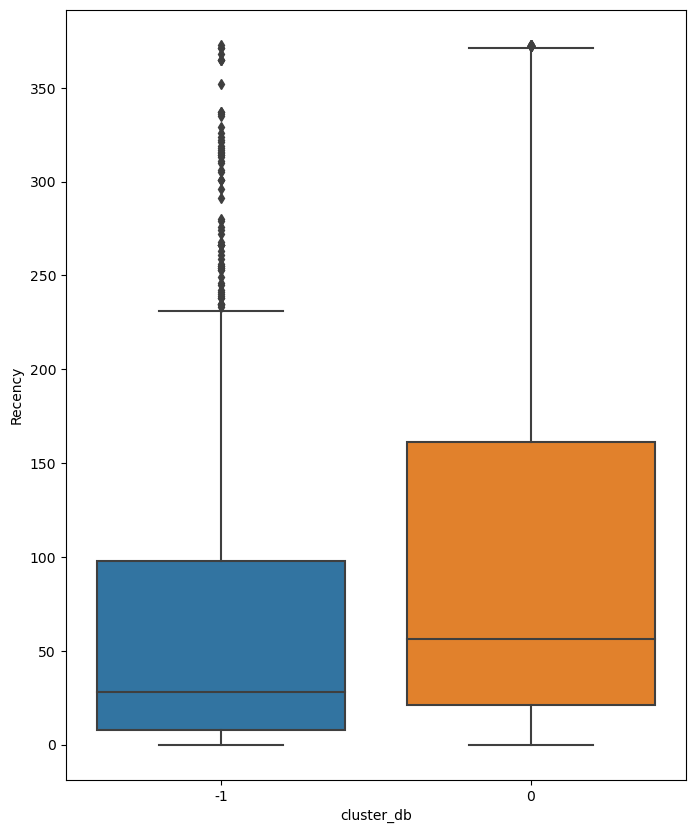

In [58]:
# Plot Cluster Id vs Recency

sns.boxplot(x='cluster_db', y='Recency', data=rfm)

# Analyse de la Sensibilité aux Paramètres 

### L'analyse de la sensibilité aux paramètres dans le contexte du clustering se fait souvent à l'aide de deux métriques : le score de silhouette et l'indice Davies-Bouldin.

Le score de silhouette mesure à quel point un objet est similaire à son propre cluster par rapport aux autres clusters. Il varie de -1 à 1, une valeur élevée indiquant une bonne correspondance au cluster et une faible correspondance aux clusters voisins.

L'indice Davies-Bouldin évalue la séparation entre les clusters. Il mesure la similarité moyenne entre chaque cluster et son cluster le plus similaire en tenant compte de la distance et de la taille des clusters.  Un indice plus bas indique une meilleure séparation.*

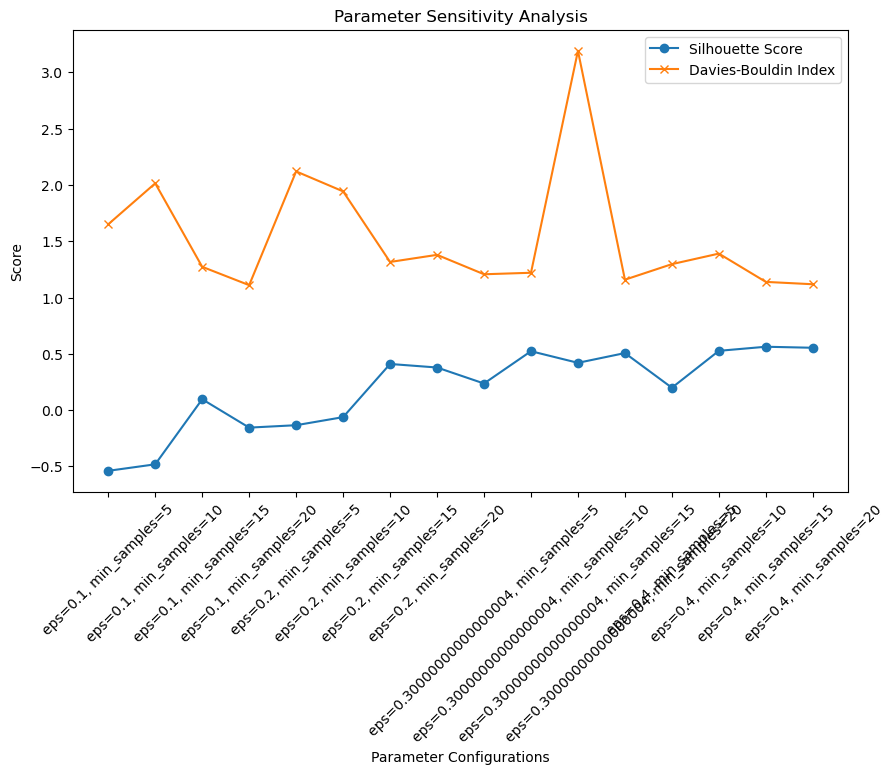

In [59]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Implementer silhouette score et Davies-Bouldin indice

silhouette_scores = []
db_indices = []
eps_values = np.arange(0.1,0.5, 0.1)
min_samples_values =np.arange(5, 25,5)

# Appliquer DBSCAN 

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(rfm_df_scaled) 
       

        # Calculer le silhouette score et indice Davies-Bouldin 
        silhouette_avg = silhouette_score(rfm_df_scaled, dbscan.labels_)
        db_index = davies_bouldin_score(rfm_df_scaled, dbscan.labels_)

        silhouette_scores.append(silhouette_avg)
        db_indices.append(db_index)

# Plotting les resultats

plt.figure(figsize=(10, 6))
plt.plot(range(len(silhouette_scores)), silhouette_scores, marker='o', label='Silhouette Score')
plt.plot(range(len(db_indices)), db_indices, marker='x', label='Davies-Bouldin Index')
plt.xticks(range(len(silhouette_scores)), [f"eps={eps}, min_samples={min_samples}" for eps in eps_values for min_samples in min_samples_values], rotation=45)
plt.xlabel('Parameter Configurations')
plt.ylabel('Score')
plt.title('Parameter Sensitivity Analysis')
plt.legend()
plt.show()

*Un score de silhouette plus élevé indique des clusters mieux définis. Pour l'indice Davies-Bouldin, un score plus bas indique une meilleure séparation. En se basant sur le paragraphe ci-dessus, le modèle que nous avons initialement choisi se révèle efficace, avec un score de silhouette élevé et un indice Davies-Bouldin bas. Cette combinaison de scores suggère que les clusters identifiés par le modèle sont bien définis et suffisamment séparés. Modèle choisi : eps=0.2, min_samples=15*

# Conclusion

Après avoir utilisé les trois algorithmes de clustering (K-Means, Hierarchical Clustering et DBSCAN) pour trouver une segmentation des clients de la vente en ligne, nous obtenons les résultats suivants :

## K-Means Clustering :

Le clustering K-Means a donné les clusters suivants :

Les clients dans le Cluster 0 ont présenté un volume significatif de transactions par rapport aux autres groupes de clients, les plaçant en tant que segment le plus précieux pour l'entreprise.
Les clients dans le Cluster 1 n'ont pas effectué d'achats récents et sont considérés comme moins cruciaux d'un point de vue commercial.
Les clients dans le Cluster 2 sont des acheteurs fréquents, contribuant à la génération de revenus, bien que dans une moindre mesure que ceux du Cluster 0.

## Hierarchical Clustering :

Le clustering hiérarchique a généré les clusters suivants :

Les clients dans le Cluster 0 n'ont pas effectué d'achats récents et sont considérés comme moins cruciaux d'un point de vue commercial.
Les clients dans le Cluster 1 ont présenté un volume significatif de transactions par rapport aux autres groupes de clients, les plaçant en tant que segment le plus précieux pour l'entreprise.
Les clients dans le Cluster 2 sont des acheteurs fréquents, contribuant à la génération de revenus, bien que dans une moindre mesure que ceux du Cluster 0.

## DBSCAN Clustering :

Le clustering DBSCAN nous a fourni les clusters suivants :

Les clients dans le Cluster 0 sont des acheteurs fréquents, contribuant à la génération de revenus.
Les clients dans le Cluster -1 n'ont pas effectué d'achats récents et sont considérés comme moins cruciaux d'un point de vue commercial.

D'un point de vue commercial, la classification K-means et les clusters hiérarchiques sont plus informatifs. En conséquence, nous effectuerons le déploiement avec le modèle K-means.

## Enregistrer le modèle

In [60]:
import pickle

with open('/Users/apple/Desktop/Model-Kmeans.pkl', 'wb') as file:
    pickle.dump(kmeans, file, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=False)


In [ ]:
!streamlit run /Users/apple/Desktop/clusterappp.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://192.168.111.224:8502

/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KMeans was fi